# PROSJEKT 2 _____________________

**TING Å ORDNE**
- likningsreferanse funker nå bare i samme celle... Gamlemåten?


## Contents
* [Introduction](#intro)
* [Theory behind methods](#method)
* [Model and assumptions](#model)
* [](#)
* [Varying the displaced-water-area](#water)
* [Boat with cargo](#cargo)
* [Boat with harmonic wave/wind-force](#w-force)
* [](#)
* [Conclusion](#conclusion)

## Introduction <a class="anchor" id="intro"></a>

In this project we will study \\

\

\

\

Adding ... to the model \\
\\
\\



A note on figures and animations??? Vi får se hvor hard vi blir slakta for sånn vi gjorde det sist. 

In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

## Theory behind methods <a class="anchor" id="method"></a>

**HVIS VI FØLER DET ER BEDRE Å SAMLE DET LITT OG REFERERE SENERE???**

In [2]:
## Libraries for maths and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm

## Library for status bar
from tqdm.notebook import tqdm

**Newtons method**



In [3]:
# 1a
def newton(f, df, x0, tol=1.e-10, max_iter=30, variable = "x"):
    """
    brief: Solves the equation f(x)=0 with Newtons method
    :param f: the function f(x)
    :param df: the derivative of f(x)
    :param x0: initial value
    :param tol: tolerance, if f(x)<tol we accept x
    :return: the accepted root, number of iterations
    """
    x = x0
    for k in range(max_iter):
        print(f"k ={k:3d}, {variable} = {x:18.15f}, f(x) = {f(x):10.3e}")
        fx = f(x)
        if norm(fx) < tol: # Accept solution 
            break 
        x = x - fx/df(x)   # One Newton-iteration
    return x, k+1

## Model and assumptions <a class="anchor" id="model"></a>


jj




<a id="fig1"></a>


<div>
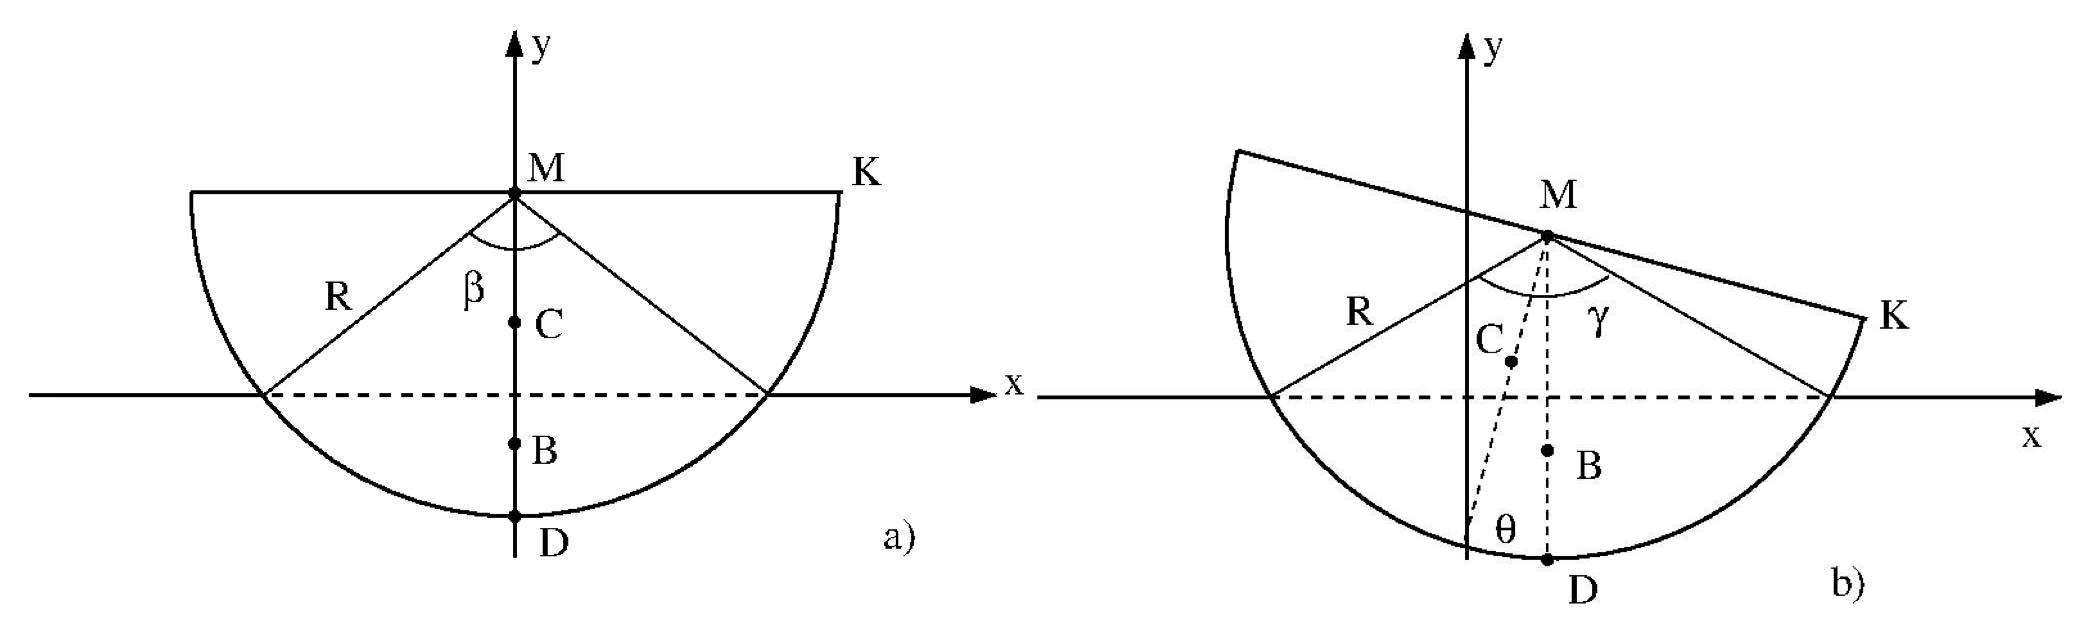
</div>


***Figure 1*** *: A sketch of our boat-model. a) The boat in equilibrium. b) The boat after displacement and rotation about the centre of mass, $C$.*




**The ship**

We will assume that the ship is long enough to neglect effects on its ends, and we are left with a two dimentional problem. We let the ship have the shape of a half-sircle with the radius $R=10 \textrm{ m}$, and give it a uniform mass distribution with density $\sigma = 500 \textrm{ kg/m}^2$. For such a shape the mass centre $C$ lies a distance 

$$ h_{CM} = 4R/3\pi, $$

below the ship's metacentre $M$. The moment of inertia about $C$ is given by:

$$I_C = \frac{1}{2} m R^2 \left( 1-\frac{32}{9\pi^2} \right).$$

In [4]:
## Defining constants that will remain the same
sigma_0 = 1000
sigma   = 500
R       = 10
A_s     = 1/2*np.pi*R**2
g       = 9.81
h_CM    = 4*R/(3*np.pi)
m       = sigma * A_s         # mass of one metre boat 
I_C     = 1/2*m*R**2*(1 - 32/(9*np.pi**2))

With Arkimedes law we can show that the ship, in equalibrium, displaces an area $A_0$ of water:

$$A_0 = \sigma \pi R^2 / 2 \sigma_0.$$

As the ship rotates about $C$ the amount of displaced water varies. We introduce the angle $\gamma$ shown in **ref**, and let $\gamma_{\textrm{equil}} = \beta$. Some geometry gives us the displaced-water-area $A$ in terms of $\gamma$: 

$$A = \frac{1}{2} R^2 (\gamma - \sin{\gamma}).$$

In [5]:
def find_A(gamma):
    return 1/2*R**2*(gamma-np.sin(gamma))

At $\gamma=\beta$ we have $A=A_0$ giving an implicit equation for $\beta$:

$$
\begin{align}
f(\beta) &= \beta - \sin {\beta} - \pi \sigma / \sigma_0 = 0.
\end{align}
$$

We will solve this equation by Newtons method. As discussed in **REF METHODS ...** we need the derivative:

$$f'(\beta) = 1 - \cos{\beta}.$$

k =  0, β =  2.000000000000000, f(x) = -4.801e-01
k =  1, β =  2.339014105903838, f(x) =  4.907e-02
k =  2, β =  2.310063196572691, f(x) =  3.042e-04
k =  3, β =  2.309881467301467, f(x) =  1.220e-08
k =  4, β =  2.309881460010057, f(x) =  4.441e-16


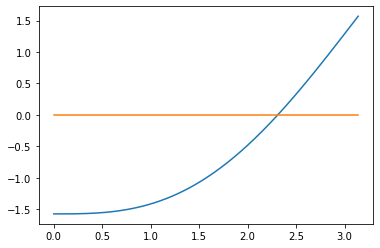

In [6]:
def find_beta_newton(b0, plot = False):
    def f(b):
        return b - np.sin(b) - np.pi*sigma/sigma_0
    def df(b):
        return 1 - np.cos(b)
    beta = newton(f, df, b0, variable = "\u03B2")[0]
    if plot:
        x = np.arange(0, np.pi, 0.01)
        plt.plot(x, f(x))
        plt.plot(x, 0*x)
    return beta

beta = find_beta_newton(2, plot = True)

An important point is the centre of the buoyant force, $B$, wich lies a distance $Y_{MB}$ below $M$:

$$Y_{MB} = R\cdot \frac{4 \sin^3{\gamma/2}}{3(\gamma - \sin{\gamma})}.$$

In [7]:
def find_yMB(gamma):
    return R*4*np.sin(gamma/2)**3 / (3*(gamma - np.sin(gamma)))

When solving the motion of the boat we will keep track of $\theta$ and $y_C$. We shall see that $\gamma$ is determined by these two values. Always knowing $\gamma$ means we can altso compute $y_M$, $y_B$ and $y_D$. If we let $y=0$ at the water level, we have:

$$
\begin{align*}
y_M (\theta, y_C) &= R \cos{\gamma/2} \\
y_B (\theta, y_C) &= y_M - Y_{MB}(\gamma) \\
y_D (\theta, y_C) &= y_M - R.
\end{align*}
$$

The points $M$, $B$ and $D$ lie on the same vertical line:

$$
\begin{align*}
x_M (\theta, x_C) &= x_C + h_{CM} \sin{\theta} \\
x_B (\theta, x_C) &= x_M  \\
x_D (\theta, x_C) &= x_M.
\end{align*}
$$



In [8]:
def find_yM(gamma):
    return R*np.cos(gamma/2)
def find_yB(gamma):
    return find_yM(gamma) - find_yMB(gamma)
def find_yD(gamma):
    return find_yM(gamma) - R

def find_xMBD(theta, xC):
    return x_C + h_CM*np.sin(theta)

For a ship in equilibrium we know $\gamma = \beta$. In equalibrium $C$ lies $h_{CM}$ below $M$:

$$
\begin{align*}
y_C^0 &= y_M(\beta) - h_{CM}. \\
\end{align*}
$$

We compute the equalibrium coordinates below:

In [9]:
# 1b - definere yM0, yC0, yB0, yD0 med vannet som nullpunkt for y

yM0 = find_yM(beta)
yC0 = yM0 - h_CM
yB0 = find_yB(beta)
yD0 = find_yD(beta)

print(yM0, yC0, yB0, yD0)

4.039727532995171 -0.2044042827887047 -2.457918503149423 -5.960272467004829


We have seen that we need to compute $\gamma$ to find displaced water area and other important quantities. keep track of $\gamma$ as it derermines the displaced water. It is determined by $\theta$ and $y_C$. We have $\cos{\gamma/2}=y_M/R$, wich gives: **TODO, SKAL VI UTLEDE HER?**

$$ \gamma (\theta, y_C)= 2\arccos{\left( \cos{\frac{\beta}{2}} - \frac{4}{3\pi}(1-\cos{\theta}) + \frac{y_C - y_C^0}{R} \right)}.$$

In [10]:
def find_gamma(theta, yC):
    return 2*np.arccos(np.cos(beta/2) - 4/(3*np.pi)*(1-np.cos(theta)) + (yC-yC0)/R)

In [figure 1](#fig1)

**Forces on the ship**




Gravity acts vertically pulling the boat down with a constant force:

$$ \vec F_G = -mg \hat y. $$

A net buoyant force pushes the boat upwards counteracting gravity. The net force acts in the centre of buoyancy, $B$, wich would have been the mass centre of the displaced water. The force is proportional to our $\gamma$-dependent displaced area:

$$ \vec F_B = \sigma_0 A g \hat y = \frac{\sigma_0gR^2}{2} (\gamma - \sin{\gamma}) \hat y.$$

We will model the friction between the boat and the water as proportional to the contact-area and angular velocity **HER MÅ VI SJEKKE OLA!!!!!!!!!! angular eller ikke...**. We let the force act in horisontaly in the deepest point $D$.

$$\vec f = -k_f R \gamma \omega \hat x.$$

We model the wind/wave force as a horisontal harmonic force acting along the water:

$$F_w(t) = F_0 \cos{\omega_w t} \hat x$$


In [11]:
def F_G():
    return -m*g
def find_F_buoyant(displaced_area):
    return sigma_0*g*displaced_area
def find_F_friction(gamma, omega, k_f):
    return -k_f*R*gamma*omega
def find_F_waves_wind(t, F_0, omega_w):
    return F_0*np.cos(omega_w*t)


Torques +++

$$
\begin{align}
    \vec \tau_B &= -F_B h_{CM} \sin{\theta} \hat z\\
    \vec \tau_f &= f\left( y_C - (R\cos{\gamma/2}-1) \right) \hat z\\
    \vec \tau_w &= F_w y_C \hat z
\end{align}
$$


In [12]:
def find_tau_buoyant(theta, F_B):
    return - F_B*h_CM*np.sin(theta)
def find_tau_friction(y_C, gamma, f):
    return f*(y_C - (R*np.cos(gamma/2) - 1))
def find_tau_waves_wind(y_C, F_w):
    return F_w*y_C


**Moving cargo**

*Figure and coordinate system*
distance s_L ....

We will assume that the cargo does not loose contact with the ship unless it slips of the edges. We will also do simulations with fences keeping the cargo from falling off. While the cargo is on the ship the forces acting from the cargo in the ship are given by:

$$
\begin{align}
    F_{L, x} (\theta) &= m_L g \cos{\theta} \sin{\theta} 
    \tag {34a} \\
    F_{L, y} (\theta) &= - m_L g \cos^2{\theta}
    \tag {34b}
\end{align}
$$

It follows from Newtons third law that the forces on the cargo are given by:

$$
\begin{align}
    F_{L, x}' (\theta) &= -m_L g \cos{\theta} \sin{\theta} 
    \tag {34a} \\
    F_{L, y}' (\theta) &= m_L g \cos^2{\theta}
    \tag {34b}
\end{align}
$$

When the ship is tilted an angle $\theta$ the net force on the cargo is along the deck, and is given by:


In [13]:
m_L = 123456789876543
def find_F_Lx(theta):
    return m_L*g*np.cos(theta)*np.sin(theta)
def find_F_Ly(theta):
    return -m_L*g*np.cos(theta)**2

$$
\vec \tau (\theta, s_L) = - m_L g \cos{\theta} s_L \hat z
$$

In [14]:
def find_tau_L(theta, s_L):
    return -m_L*g*np.cos(theta)*s_L

**Capsizing thr boat**

We say that our boat has capsized if part of the deck is below the water level. (The engineers thought it was a bright idea to have a drain into a ... INSERT JOKE).


<div>
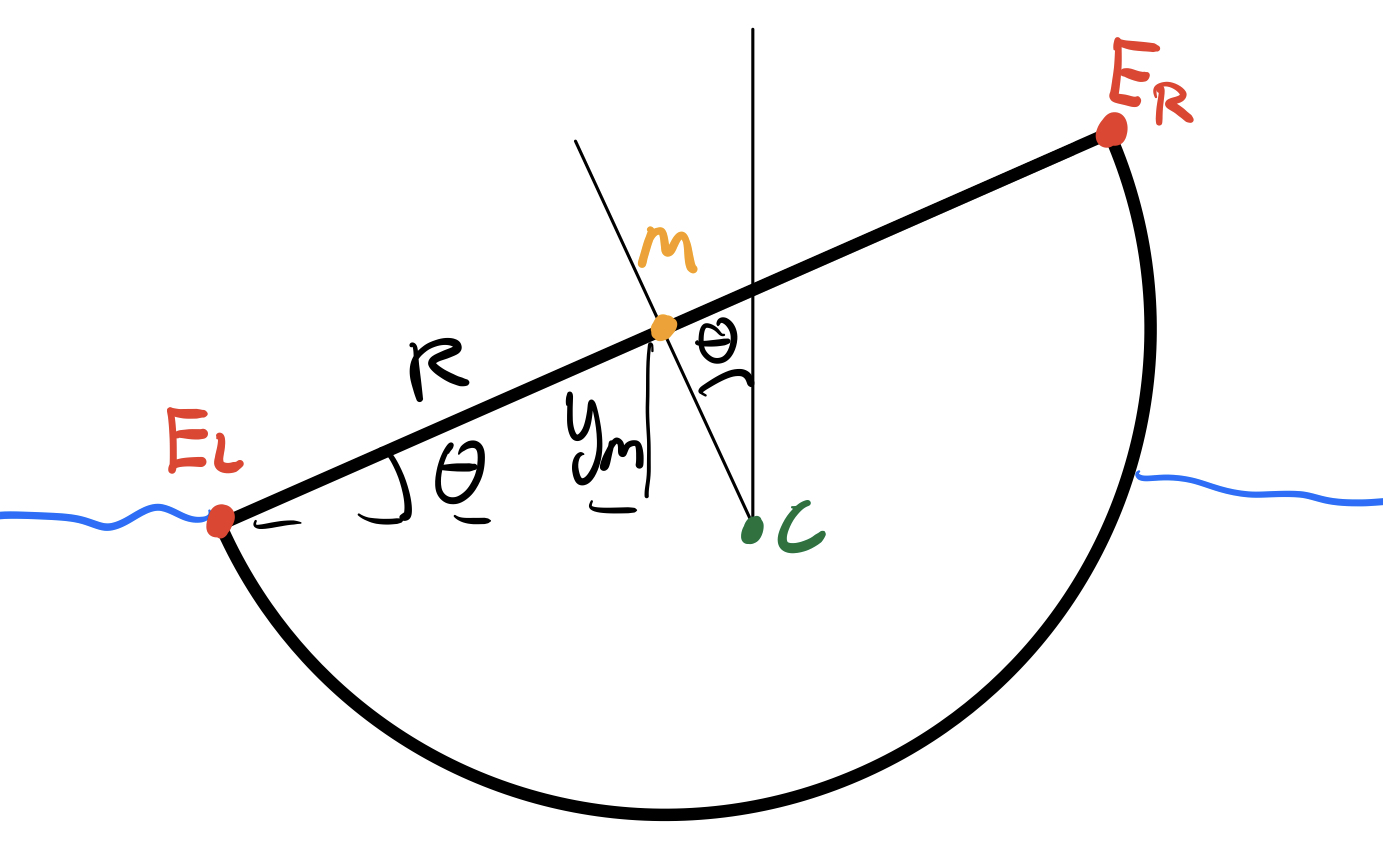
</div>

To see if our boat has capsized we keep track of the y-coordinate of the left and right endpoints $E_L$ and $E_R$:

$$
\begin{align}
    y_{E_L} &= y_M - R \sin{\theta} \\
    y_{E_R} &= y_M + R \sin{\theta}
\end{align}
$$


In [15]:
def boat_has_capsized(theta, yC):
    yM = find_yM(find_gamma(theta, yC))
    yEL = yM - R*np.sin(theta)
    yER = yM + R*np.sin(theta)
    return (yEL < 0 or yER < 0)

Introducing the vector 
$\vec{w} = \begin{bmatrix} \theta(t) & 
                           \omega(t) & 
                           x_C(t) & 
                           v_{x_C}(t) & 
                           y_C(t) & 
                           v_{y_C}(t) & 
                           s_L(t) & 
                           v_{L}(t)\end{bmatrix}^T$ 
we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \Sigma\tau_C(t)/I_C \\
                  v_{C, x}(t) \\
                  \Sigma F_{C, x}(t)/m \\
                  v_{C, y}(t) \\
                  \Sigma F_{C, y}(t)/m \\
                  v_{L}(t)\\
                  \Sigma F_{L, \hat s}(t)/m\end{bmatrix}.$$


## VISUALISERING _____ TITTEL BYTTES

A note on the animation-code ...

modified to save animations +++

blblb


In [16]:
import matplotlib.animation
from IPython.display import HTML, clear_output

def animate_boat(t, theta, x_C, y_C, s_L=[], gjerde=False, stepsize=0.01, vis_akse_verdier=False, gif_name = "TEST"):
    """
    """
    fig, ax = plt.subplots()
    boat,           = ax.plot([], [], color="k", linewidth=2)
    deck,           = ax.plot([], [], color="k", linewidth=2)
    sea_surface,    = ax.plot([-R*10, R* 10], [0, 0], color='blue', linewidth=2)  # The surface
    last,           = ax.plot([], [], color="r", marker="o", markersize=10)
    CM,             = ax.plot([], [], color="g", marker="o", markersize=10)
    MS,             = ax.plot([], [], color="y", marker="o", markersize=10)
    venstre_gjerde, = ax.plot([], [], color="k", marker="|", markersize=25)
    høyre_gjerde,   = ax.plot([], [], color="k", marker="|", markersize=25)
    ax.set_xlim([-R*1.3, R* 1.3])
    ax.set_ylim([-R*1.1, R* 1.1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect("equal")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textbox_theory = ax.text(3, 10, '', fontsize=12,
                             ha = 'left', va = 'top')
                             
    # call this function for every frame in the animation
    def animate(M):
        ax.set_xlim([-R * 1.1 + np.amin(x_C), R * 1.1 + np.amax(x_C)])
        ax.set_ylim([-R*1.1, R* 1.1])
        angle_values = np.linspace(0, np.pi, 100)
        metasenter_x = x_C[M] - h_CM * np.sin(theta[M])
        metasenter_y = y_C[M] + h_CM * np.cos(theta[M])
        xs = R * np.cos(angle_values + np.pi + theta[M]) + metasenter_x
        ys = R * np.sin(angle_values + np.pi + theta[M]) + metasenter_y
        boat.set_data(xs, ys)
        deck.set_data([xs[0], xs[-1]], [ys[0], ys[-1]])
        if False: #s_L[M] !=-42:
            last.set_data(metasenter_x + s_L[M] * np.cos(theta[M]),
                          metasenter_y + s_L[M] * np.sin(theta[M]))
        CM.set_data(x_C[M], y_C[M])
        MS.set_data(metasenter_x, metasenter_y)
        if gjerde:
            venstre_gjerde.set_data([metasenter_x - R * np.cos(theta[M])], [metasenter_y - R * np.sin(theta[M])])
            høyre_gjerde.set_data([metasenter_x + R * np.cos(theta[M])], [metasenter_y + R * np.sin(theta[M])])
        theta_string= r'$\theta = %.2f$' % (theta[M] * 180 / np.pi) + r"$\degree$"
        time_string = '$t =  %.2f$' % (t[M])
        textbox_theory.set_text(
            theta_string + '\n' + time_string)

        if M % 1000 == 0:
            print(M)
        
    # create matplotlib animation object
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t), repeat=False, interval=1)
    ani.save(f'animations/{gif_name}.gif')

Plotting ...

In [17]:
def plot_function(x_vals_list, y_vals_list, file_title, title = "",
                  xlabel = "", ylabel = "", fig_size = (9, 5), title_scale_factor = 80,
                  labels = False, loc = "upper right"):
    """
    brief: plots x_vals_list[i] vs y_vals_list[i] and saves to file_title
    :param x_vals_list: list of list, list of x_vals to be plotted
    :param y_vals_list: list of list, list of y_vals to be plotted agains x_vals
    :param file_title: string, filename to save the plote
    :param title: string, title of plot
    :param xlabel: string, label of x-axis
    :param ylabel: string, label of y-axis
    :param fig_size: (int, int), figure size
    :param title_scale_factor: int, determines size of title
    :param labels: boolean=False, if true presents plot with legends
    :param loc: string=upper right, determines where legend is
    :return:
    """
    fig = plt.figure(figsize=fig_size)
    for i in range(len(y_vals_list)):
        plt.plot(x_vals_list[i], y_vals_list[i])
    title_size = int(title_scale_factor * fig_size[0] / len(title))
    plt.title(title, size = title_size)
    label_size = int(2/3 * title_size)
    plt.xlabel(xlabel, size = label_size)
    plt.ylabel(ylabel, size = label_size)
    if labels:
        plt.legend(labels, loc = loc)
    fig.savefig(f'figures/{file_title}.png') # save first frame

## FØRSTE DEL <a class="anchor" id="FØRSTE"></a>

## SIMPLE MODEL SOMETHING SOMETHINg

**HER TAR VI ALL MODELLERING SOM GJENSTÅR I OPPGAVE 1**

We now calculate the points ... **REF** in equilibrium. 

We begin our modelling of the boat with a very simple model. We assume that the centre of mass stays fixed and ignore all forces but the bouyancy. $C$ remains fixed by pretending that the displaced area $A$ is constant and equal to $A_0$.Thus $\Sigma F_y = F_B - F_G = 0$. Only the torque from the bouyancy, $\tau_B$, contributes to motion:


$$
\begin{equation}
\sum{\tau} = I_C \ddot{\theta} = - F_B h_{CM} \sin{\theta}. \\
\label{eq:HO_tau}
\end{equation}
$$

$\eqref{eq:HO_tau}$ **MÅ FINNE UT AV LIKNINGSNUMMER**

We introduce the angular velocity $\omega = \dot{\theta}$ and split the problem into a system of first order equations:

$$
\begin{align*}
\frac{\textrm{d}\theta}{\textrm{d}t} &= \omega \\ 
\frac{\textrm{d}\omega}{\textrm{d}t} &= - \frac{F_B h_{CM}}{I_C} \sin{\theta}. \\
\end{align*}
$$

Introducing the vector $\vec{w} = \begin{bmatrix} \theta(t) & \omega(t) \end{bmatrix}^T$ we can write our problem on the standard form $\frac{\textrm{d}\vec{w}}{\textrm{d}t} = \vec f(t, \vec w) $:

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\ \omega(t) \end{bmatrix} 
= \begin{bmatrix} \omega \\ - \frac{F_B h_{CM}}{I_C} \sin{\theta}\end{bmatrix}.$$

The variable $F_B$ is given by:

$$F_B = \sigma_0 A_0 g = \frac{\sigma_0gR^2}{2} (\beta - \sin{\beta}) $$ 

In [18]:
def f_harmonic_oscillator(t, w):
    """
    brief: the derivative of the vector w = [theta, omega]
           only including the harmonic restorative buoyant force
    :param theta: current angle
    :param omega: current angular velocity
    :return: the derivative
    """
    tau_B = find_tau_buoyant(w[0], find_F_buoyant(find_A(beta)))
    return np.array([w[1], tau_B/I_C, w[3], 0, w[5], 0, w[7], 0])

In [19]:
# 1d
def euler_method(f, t, w, h):
    """
    brief: One step of Eulers method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    t_next = t + h
    w_next = w + h*f(t, w)
    return t_next, w_next

def ode_solver(f, t0, t_end, w0, h, method=euler_method):
    """
    brief: Solves the ode w' = f(t, w) with method of choice
    :param f: the function f(x)
    :param t0: initial t-value
    :param t_end: the final t-value
    :param w0: initial w-value
    :param h: stepsize
    :param method: the method used in each step
    :return: the next value for tn and wn
    """
    #Create arrays to store values
    t_num = np.array([t0])    
    w_num = np.array([w0])    

    # Values that are updated for each iteration
    tn = t0                
    wn = w0 
    
    # Main loop
    capsized = boat_has_capsized(wn[0], wn[2])
    capsize_index = 0
    while tn < t_end - 1.e-10:# and !boat_has_capsized(w[0], ):           # Buffer for truncation errors        
        
        if not capsized:
            capsized      = boat_has_capsized(wn[0], wn[4])
            capsize_index = int(tn / h)

        if t_end - tn < h:
            if capsized:
                tn += t_end - tn
                wn = np.array([np.pi/2 * np.sign(wn[0]), 0, 0, 0, max(-R, wn[4]-0.2), 0, 0, 0])
            else:
                tn, wn = method(f, tn, wn, t_end - tn) # Do last step             
        else:
            if capsized:
                tn += h
                wn = np.array([np.pi/2 * np.sign(wn[0]), 0, 0, 0, max(-R, wn[4]-0.2), 0, 0, 0])
            else:
                tn, wn = method(f, tn, wn, h)    # Do one step 

        # Add values to array
        t_num = np.append(t_num,tn)
        w_num = np.concatenate((w_num, np.array([wn])))
    
    return t_num, w_num

**RETTFERDIGGJØR VALG AV h**

We will now solve the equation with Eulers method. We start the ship at $\theta_0 = 20^\circ$ and $\omega_0 = 0$. We start the iterations at $t=0\textrm{ s}$ and let it run for $20 \textrm{s}$.

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0


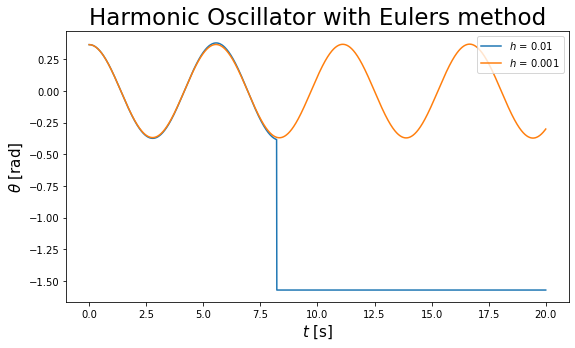

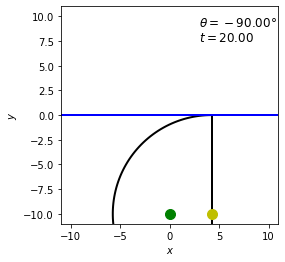

In [20]:
# 1d) 

t0 = 0
t_end = 20
w0 = np.array([21*np.pi/180, 0, 0, 0, yC0, 0, 0, 0])
h_list = [0.01, 0.001]
times = []
theta = []
yC    = []
for h in h_list:
    t_num, w_num = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
    times.append(t_num)
    theta.append(np.array([w_num[i][0] for i in range(len(w_num))]))
    yC.append(np.array([w_num[i][4] for i in range(len(w_num))]))
    
plot_function(times, theta, f'HO_euler_3h', title = f"Harmonic Oscillator with Eulers method",
                  xlabel = r"$t$ [s]", ylabel = r"$\theta$ [rad]", fig_size = (9, 5), title_scale_factor = 100,
                  labels = [f"$h$ = {h}" for h in h_list], loc = "upper right")

#def animate_boat(t, theta, x_C, y_C, s_L=[], gjerde=False, stepsize=0.01, vis_akse_verdier=False, gif_name = "TEST"):
animate_boat(times[0][::10], theta[0][::10], 0*yC[0][::10], yC[0][::10])

Compare solution to HO:

With the small angle approximation our system becomes:



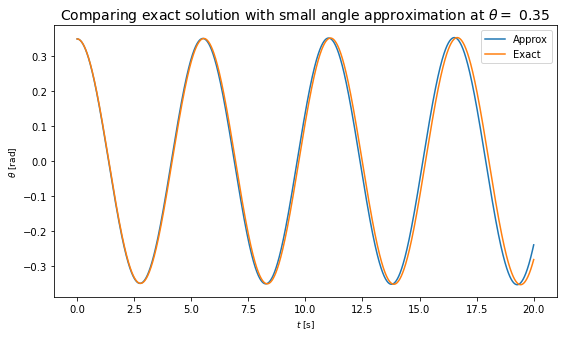

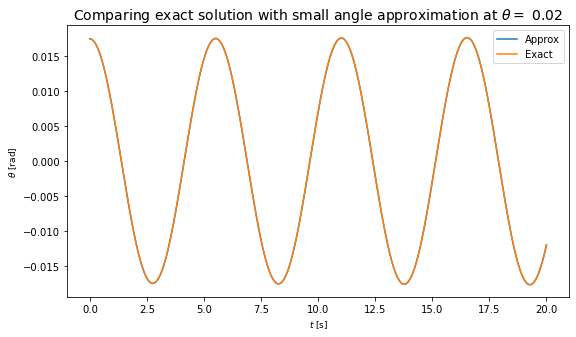

In [21]:
# 1e

def f_harmonic_approxilator(t, w):
    """
    brief: the derivative of the vector w = [theta, omega]
           only including the harmonic restorative buoyant force,
           now with small angle approximation
    :param theta: current angle
    :param omega: current angular velocity
    :return: the derivative
    """
    F_B = find_F_buoyant(find_A(beta))
    return np.array([w[1], - F_B*h_CM/I_C*w[0], w[3], 0, w[5], 0, w[7], 0])

h = 0.001
Theta = [20*np.pi/180, 1*np.pi/180]

for theta in Theta:
    w0 = [theta, 0, yC0, 0, 0, 0, 0, 0]
    
    t_approx, w_approx = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)
    theta_approx = np.transpose(w_approx)[0]
    
    t_exact, w_exact   = ode_solver(f_harmonic_oscillator, t0, t_end, w0, h, method=euler_method)
    theta_exact = np.transpose(w_exact)[0]
    
    plot_function([t_approx, t_exact], [theta_approx, theta_exact], f'small_angle_comp_{round(theta, 2)}', 
                  title = r"Comparing exact solution with small angle approximation at $\theta =$ " + f"{round(theta, 2)}",
                  xlabel = r"$t$ [s]", ylabel = r"$\theta$ [rad]", fig_size = (9, 5), title_scale_factor = 120,
                  labels = ["Approx", "Exact"], loc = "upper right")
    

In [22]:
# 1f

def RK4_method(f, t, w, h):
    """
    brief: One step of RK4 method
    :param f: the function f(t, w)
    :param t: current t-value
    :param w: current w-value
    :param h: stepsize
    :return: the next value for tn and wn
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)    
    
    t_next = t + h
    w_next = w + h/6*(k1 + 2*k2 + 2*k3 + k4)
    return t_next, w_next

UTLEDE ANALYTISK

$\eqref{eq:HO_tau}$

$$
\ddot{\theta} - \frac{F_B h_{CM}}{I_C} {\theta} = 0\\
$$

$$
\tilde{\theta} (t) = \theta_0 cos\left(\sqrt{\frac{F_B h_{CM}}{I_C}}t\right).
$$

In [23]:
# 1g
def analytic_harmonic_oscillator(time_array, theta0):
    F_B = find_F_buoyant(find_A(beta))
    return theta0*np.cos(np.sqrt(F_B*h_CM/I_C)*time_array)

In [24]:
#1h

N = 100
h_array = np.linspace(1e-2, 1e-3, N)
global_error_euler = np.zeros(N)
global_error_RK4   = np.zeros(N)
w0 = [0.01, 0, 0, 0, yC0, 0, 0, 0] # [theta0, omega0, x0, vx0, y0, vy0, s0, vs0]
t0 = 0
t_end = 20
for i in tqdm(range(len(h_array))):
    h = h_array[i]
    theta_anal  = analytic_harmonic_oscillator(t_end, w0[0])
    o, w_euler = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=euler_method)
    o, w_RK4   = ode_solver(f_harmonic_approxilator, t0, t_end, w0, h, method=RK4_method)
    global_error_euler[i] = np.abs(theta_anal - w_euler[-1][0])
    global_error_RK4[i]   = np.abs(theta_anal - w_RK4[-1][0])

  0%|          | 0/100 [00:00<?, ?it/s]

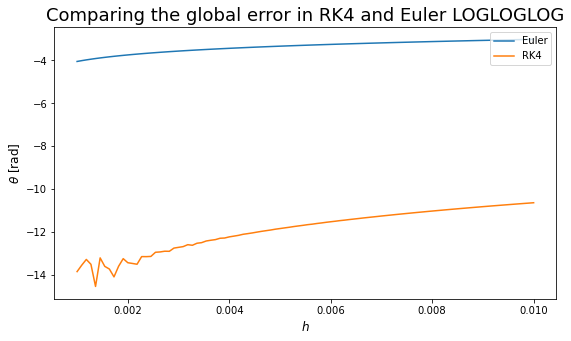

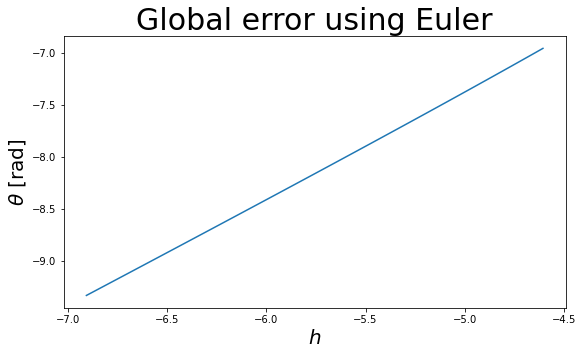

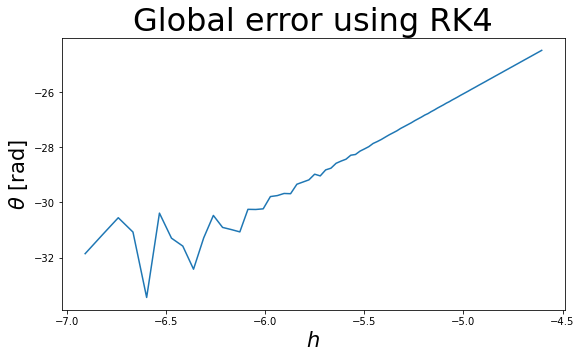

In [25]:
plot_function([h_array, h_array], [np.log10(global_error_euler), np.log10(global_error_RK4)], f'error_RK4_VS_Euler', 
                  title = r"Comparing the global error in RK4 and Euler LOGLOGLOG",
                  xlabel = r"$h$", ylabel = r"$\theta$ [rad]", fig_size = (9, 5), title_scale_factor = 110,
                  labels = ["Euler", "RK4"], loc = "upper right")

plot_function([np.log(h_array)], [np.log(global_error_euler)], f'error_Euler', 
                  title = r"Global error using Euler",
                  xlabel = r"$h$", ylabel = r"$\theta$ [rad]", fig_size = (9, 5), title_scale_factor = 80,
                  labels = False, loc = "upper right")

plot_function([np.log(h_array)], [np.log(global_error_RK4)], f'error_RK4', 
                  title = r"Global error using RK4",
                  xlabel = r"$h$", ylabel = r"$\theta$ [rad]", fig_size = (9, 5), title_scale_factor = 80,
                  labels = False, loc = "upper right")

**VI MÅ SE PÅ ØVINGA DER MAN FINNER ORDEN GRAFISK...**

In [26]:
# # HVORDAN FÅ FIGURTEKST PÅ PLOT
# from matplotlib import pyplot as plt
# import numpy as np
# x=np.arange(-10,10,0.1)
# txt="Figure 3. Values collected by user4545 are plotted."
# plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=14)
# plt.plot(x,x**3);

## Varying displaced-water-area <a class="anchor" id="water"></a>

**Varying displaced-water-area**

We will now include the effekt of changing the area of displaced water. Our system becomes

$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  \tau_B(t)/I_C \\
                  0 \\
                  0 \\
                  v_{C, y}(t) \\
                  (F_B(t)-F_G)/m \\
                  0\\
                  0\end{bmatrix}.$$


In [27]:
# 2a

def f_bouncing(t, w):
    """

    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    tau_B = find_tau_buoyant(w[0], F_B)
    
    dtheta = w [1]
    domega = tau_B/I_C
    dy_C   = w [5]
    dv_Cy  = (F_B + F_G())/m
    return np.array([dtheta, domega, 0, 0, dy_C, dv_Cy, 0, 0])

MovieWriter ffmpeg unavailable; using Pillow instead.


0
0


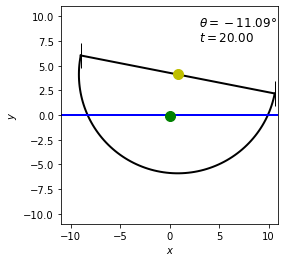

In [28]:
# 2b

w0 = [20*np.pi/180, 0, 0, 0, 0, 0, 0, 0]
h = 0.01
t_vals, w_vals = ode_solver(f_bouncing, t0, t_end, w0, h, method=RK4_method)
theta = np.transpose(w_vals)[0]
xC = np.transpose(w_vals)[2]
yC = np.transpose(w_vals)[4]
animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

[0.000e+00 1.000e-02 2.000e-02 ... 1.998e+01 1.999e+01 2.000e+01]


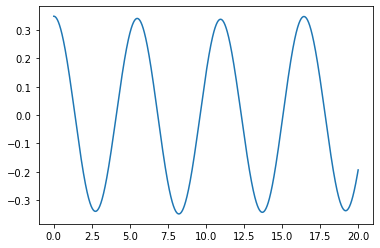

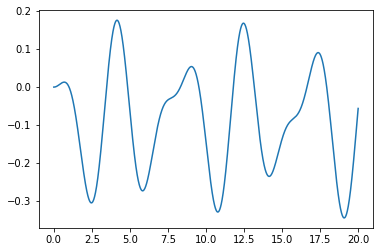

In [29]:
print(t_vals)
plt.plot(t_vals, theta)
plt.show()
plt.plot(t_vals, yC)

In [30]:
## PLOTTE SAMMEN MED LØSNING UTEN VANN VARIASJON?????

## Boat with cargo <a class="anchor" id="cargo"></a>




$$ \frac{\textrm{d}}{\textrm{d}t} \begin{bmatrix} \theta(t) \\
                           \omega(t) \\
                           x_C(t) \\
                           v_{C, x}(t) \\
                           y_C(t) \\
                           v_{C, y}(t) \\
                           s_L(t) \\
                           v_{L}(t)\end{bmatrix} 
= \begin{bmatrix} \omega(t) \\ 
                  (\tau_B(t)+\tau_L(t))/I_C \\
                  0 \\
                  0 \\
                  v_{C, y}(t) \\
                  (F_B(t)-F_G)/m \\
                  0\\
                  0\end{bmatrix}.$$
                  
                  


In [51]:
# 2d + 2e
##LAST -> masse endres og vi må beregne likevektstørrelser på nytt!!##


def f_cargo_without_fence(t, w):
    """
    Her skal vi kaste av klossen. SKråttkast og difflikning i vannet? neida... den er jo uendelig dense, dårlig med oppdrift da

    
    Når |s| > R må vi fjærne lasten fra problemet på et vis. 

    """
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    global m_L
    if abs(w[6]) > R:
        m_L = 0
        dv_L = 0
    else:
        dv_L   = g*np.sin(w[0])
        
    dtheta = w [1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w [5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m
    ds_L   = w[7]
    
        
    
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])

def f_cargo_with_fence(t, w):
    """
    Her må vi sjekke om lasten er på kanten. Hvis helningen er ned mot aktuell kant
    skal ikke klossen aksellerere langs dekket. 
    """
    
    gamma = find_gamma(w[0], w[4])
    A     = find_A(gamma)
    F_B   = find_F_buoyant(A)
    F_Ly  = find_F_Ly(w[0])
    F_Lx  = find_F_Lx(w[0])
    tau_B = find_tau_buoyant(w[0], F_B)
    tau_L = find_tau_L (w[0], w[6])
    
    dtheta = w [1]
    domega = (tau_B+tau_L)/I_C
    dx_C   = w[3]
    dv_Cx  = F_Lx/m
    dy_C   = w [5]
    dv_Cy  = (F_B + F_G() + F_Ly)/m 
    
    if w[6] >= R and w[0] > 0:
        ds_L = 0
        dv_L = 0
    elif w[6] <= -R and w[0] < 0:
        ds_L = 0
        dv_L = 0
    else:
        ds_L = w[7]
        dv_L = g*np.sin(w[0])
        
    return np.array([dtheta, domega, dx_C, dv_Cx, dy_C, dv_Cy, ds_L , dv_L])



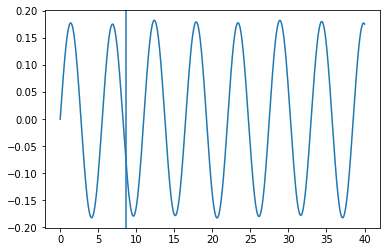

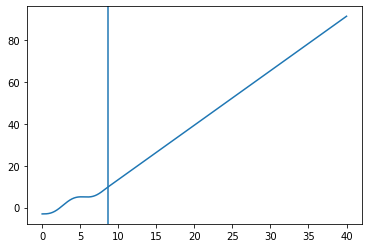

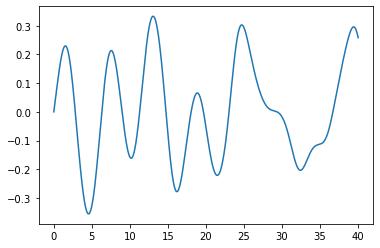

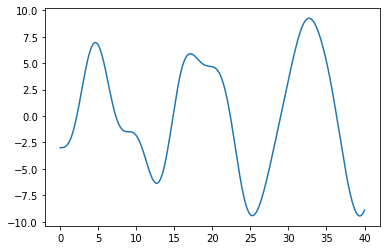

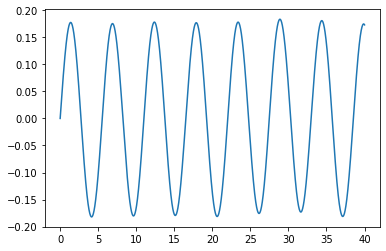

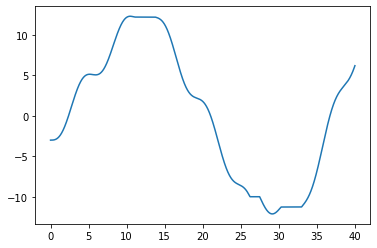

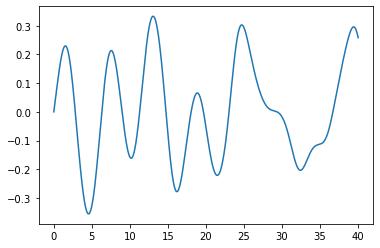

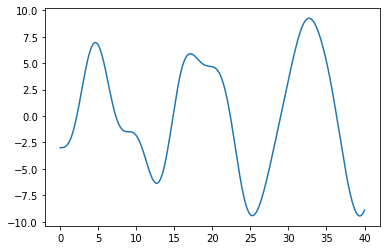

In [70]:
def find_cargo_offboard(s_L): 
    #returns: index of which cargo falls off board, zero if cargo stays on board the whole time
    
    for i in range(len(s_L)):
        if abs(s_L[i]) > R:
            return i
    return 0

t_end = 40
w0 = [0, 0.2, 0, 0, 0, 0, -3, 0]
h = 0.01

m_L = 0.001*m
t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
theta = np.transpose(w_vals)[0]
s_L = np.transpose(w_vals)[6]
cargo_offboard = find_cargo_offboard(s_L)

#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, theta)
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])
plt.show()
plt.plot(t_vals, s_L)
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])
plt.show()

m_L =0.08*m
t_vals, w_vals = ode_solver(f_cargo_without_fence, t0, t_end, w0, h, method=RK4_method)
theta = np.transpose(w_vals)[0]
s_L = np.transpose(w_vals)[6]
cargo_offboard = find_cargo_offboard(s_L)
#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, theta)
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])
plt.show()
plt.plot(t_vals, s_L)
if (cargo_offboard != 0):
    plt.axvline(t_vals[cargo_offboard])
plt.show()


m_L = 0.001*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = np.transpose(w_vals)[0]
s_L = np.transpose(w_vals)[6]
#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, theta)
plt.show()
plt.plot(t_vals, s_L)
plt.show()

m_L =0.08*m
t_vals, w_vals = ode_solver(f_cargo_with_fence, t0, t_end, w0, h, method=RK4_method)
theta = np.transpose(w_vals)[0]
s_L = np.transpose(w_vals)[6]
#animate_boat(t_vals[::10], theta[::10], xC[::10], yC[::10], gjerde = True, vis_akse_verdier = False)

plt.plot(t_vals, theta)
plt.show()
plt.plot(t_vals, s_L)
plt.show()





## Boat with harmonic wave/wind-force <a class="anchor" id="w-force"></a>

In [ ]:
# 2f + 2g

In [ ]:
# 2f

In [ ]:
# 2g

## ÅPEN oppgave <a class="anchor" id="w-force"></a>

In [ ]:
# 2h

## Conclusion <a class="anchor" id="conclusion"></a>

We have found, we have shown

## KODEBANK, søppel++

In [ ]:
# def victor():
#     def func(x, y):
#         val = 2.8*x**2 * (x**2*(2.5*x**2+y**2-2)+1.2*y**2 * (y*(3*y-0.75)-6.0311)+3.09)+0.98*y**2 * ((y**2-3.01)*y**2+3)-1.005
#         return abs(val) < 0.02
#     n = 3000
#     x = np.linspace(-2, 2, n)
#     y = np.linspace(-2, 2, n)
#     grid = np.zeros((n, n))
#     y, x = np.meshgrid(x, y)
#     z = func(x, y)
#     z = z[:-1, :-1]
#     z_min, z_max = 0, 1
#     fig, ax = plt.subplots()
#     c = ax.pcolormesh(x, y, z, vmin=z_min, vmax=z_max)
#     ax.set_title('Viktooooor')
#     ax.axis([x.min(), x.max(), y.min(), y.max()])
#     fig.colorbar(c, ax=ax)
#     plt.show()

# victor()


In [ ]:
When rotating about $C$ the point $M$ moves in a circular motion. When rotating an angle $\theta$ its coordinates change:

$$
\begin{align*}
\Delta_{\theta} x_M &= -h_{CM} \sin{\theta} \\
\Delta_{\theta} y_M &= h_{CM}(\cos{\theta}-1)
\end{align*}
$$

When the boat rotates about $C$ there is no change in $\vec{r}_C$. Since $D$ lies at a constant vertical distance from $M$, its vertical displacement due to rotation is the same as $M$. $B$ is allways a distance $Y_{MB}(\gamma)$ below $M$. If $C$ translates $\Delta \vec{r}_C = \Delta x_C \hat{x} + \Delta y_C \hat{y}$, so does every other point on the boat. We can now write every point in terms of $y_C$ and $\theta$:
TUNGVINDT...
$$
\begin{align*}
y_M (\theta, y_C) &= y_M^0 + \Delta_{\theta} y_M + \Delta y_C = R \cos{\beta/2} - h_{CM} \sin{\theta} + y_C-y_C^0 \\
y_B (\theta, y_C) &= y_M + Y_{MB}(\gamma) + \Delta y_C         = y_B(\theta = 0) + \Delta y_C       = y_M^0 - Y_{MB}(\beta)= R \cos{\beta/2} - R\cdot \frac{4 \sin^3{\beta/2}}{3(\beta - \sin{\beta})} \\
y_D (\theta, y_C) &= y_M + R = y_M^0 - R= R \cos{\beta/2} - R
\end{align*}
$$
TUNGVINDT...


Tyngdepunktet til vannet:


I likevekt har vi:

$$
\begin{equation}
\mathbf{r} \equiv \begin{bmatrix}
y \\
\theta
\end{bmatrix}
\label{eq:vector_ray}
\end{equation}
$$

Vector **r** is defined by equation $\eqref{eq:vector_ray}$
$\eqref{eq:vector_ray}$

En vinkel $\theta$ og en forflytning $\Delta y$ fra likevekt har vi:
$$
\begin{align}
y_M(\theta ) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &= R \cos{\beta/2} + (4R/3\pi)(\cos{\theta}-1) + \Delta y\\
y_M(\theta) &=69
\end{align}
$$




In [ ]:
'''Denne koden animerer bevegelsen til båtet, gitt at dere sender inn arrays som inneholder tidsverdier t,
skipets helningsvinkel theta, x- og y-koordinatet til skipets massesenter. Disse arraysene brukes i funksjonen
definert nederst "animate_deck_movement". Den grønne sirkelen viser posisjonen til skipets massesenter
Man kan sende inn optional argumenter, disse står beskrevet i funksjonen. For eksempel kan man sende inn et array
som inneholder lastens posisjon relativt metasenteret. Lasten vil da animeres som en rød sirkel.
'''
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np



# M = metasenteret = midt paa dekk
# C = skipets tyngdepunkt


R = 10  # skipets radius (m)
h = 4 * R / (3 * np.pi)  # avstand M - C

def init_anim():
    """ Initialises the animation.
    """

    global ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory
    boat, = plt.plot([], [],
                    color="k", linewidth=1)
    deck, = plt.plot([], [], color="k", linewidth=1)
    sea_surface, = plt.plot([-R*10, R* 10], [0, 0], color='blue', linewidth=2)  # The surface
    last, = plt.plot([], [], color="r", marker="o", markersize=10)
    CM, = plt.plot([], [], color="g", marker="o", markersize=10)
    venstre_gjerde, = plt.plot([], [], color="k", marker="|", markersize=25)
    høyre_gjerde, = plt.plot([], [], color="k", marker="|", markersize=25)
    ax.set_xlim([-R*1.3, R* 1.3])
    ax.set_ylim([-R*1.1, R* 1.1])
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_aspect("equal")
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    textbox_theory = ax.text(0.775, 0.95, '', transform=ax.transAxes, fontsize=12,
                             verticalalignment='top', bbox=props)

    return ax, boat, deck, last, CM,venstre_gjerde,høyre_gjerde, textbox_theory


def animate(M, theta, t, x_C, y_C, s_L, gjerde=False):
    global ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory
    ax.set_xlim([-R * 1.1 + np.amin(x_C), R * 1.1 + np.amax(x_C)])
    ax.set_ylim([-R*1.1, R* 1.1])
    angle_values = np.linspace(0, np.pi, 100)
    metasenter_x = x_C[M] - h * np.sin(theta[M])
    metasenter_y = y_C[M] + h * np.cos(theta[M])
    xs = R * np.cos(angle_values + np.pi + theta[M]) + metasenter_x
    ys = R * np.sin(angle_values + np.pi + theta[M]) + metasenter_y
    boat.set_data(xs, ys)
    deck.set_data([xs[0], xs[-1]], [ys[0], ys[-1]])
    if s_L[M] !=-42:
        last.set_data(metasenter_x + s_L[M] * np.cos(theta[M]),
                      metasenter_y + s_L[M] * np.sin(theta[M]))
    CM.set_data(x_C[M], y_C[M])
    if gjerde:
        venstre_gjerde.set_data([metasenter_x - R * np.cos(theta[M])], [metasenter_y - R * np.sin(theta[M])])
        høyre_gjerde.set_data([metasenter_x + R * np.cos(theta[M])], [metasenter_y + R * np.sin(theta[M])])
    theta_string= r'$\theta = %.2f$' % (theta[M] * 180 / np.pi) + r"$\degree$"
    time_string = '$t =  %.2f$' % (t[M])
    textbox_theory.set_text(
        theta_string + '\n' + time_string)

    M += 1
    return ax, boat, deck, last, CM, venstre_gjerde, høyre_gjerde, textbox_theory


def animate_deck_movement(t, theta, x_C, y_C, s_L=[], gjerde=False, stepsize=0.01, vis_akse_verdier=False):
    """

    :param t: Array som inneholder tidsverdiene man har beregnet \vec{w} for systemet
    :param theta: Array som inneholder utslagsvinkelen til skipet
    :param x_C: Array som inneholder massesenterets x-koordinat
    :param y_C: Array som inneholder massesenterets y-koordinat
    :param s_L: Optional array som inneholder lastens posisjon relativt massesenteret
    :param gjerde: Optional Boolean som forteller om vi skal tegne inn gjerder på skipet
    :param stepsize: Hvor lang tid som skal gå mellom hver frame
    :param vis_akse_verdier: Hvis akse-verdier vises går animasjonen litt mer hakkete, men man kan se tallverdier
    :return: Animasjon som viser dynamikken til skipet
    """
    global fig, ax
    fig, ax = plt.subplots()
    dt = t[1] - t[0]
    skips = max(int(stepsize / dt), 1)
    theta_anim = theta[::skips]
    t_anim = t[::skips]
    x_C_anim = x_C[::skips]
    y_C_anim = y_C[::skips]
    if len(s_L) == 0:
        s_L_anim = -42 * np.ones(len(theta_anim))
    else:
        s_L_anim = s_L[::skips]
    h_anim = animation.FuncAnimation(fig, animate, init_func=init_anim, frames=len(t_anim) - 1, interval=1,
                                     blit=not vis_akse_verdier,
                                     fargs=(theta_anim, t_anim, x_C_anim, y_C_anim, s_L_anim, gjerde))
    
    h_anim.save(f'test.gif')
    fig.savefig('test.jpg')
    plt.show()

    
N = 1000
t = np.linspace(0, 20, N)
theta = analytic_harmonic_oscillator(t, 0.2)
xC = np.zeros(N)
yC = yC0*np.ones(N)
animate_deck_movement(t, theta, xC, yC)

In [ ]:

    
# def analytic_harmonic_oscillator(time_array, theta0):
#     return theta0*np.cos(np.sqrt(F_B*h_CM/I_C)*time_array)

# F_B = 500
# h_CM = 4 # TEST
# I_C  = 345 # TEST
# yC0 = -0.5

# N = 1000
# t = np.linspace(0, 20, N)
# theta = analytic_harmonic_oscillator(t, 0.2)
# xC = np.zeros(N)
# yC = yC0*np.ones(N)
# animate_boat(t[::10], theta[::10], xC, yC, gjerde = True, vis_akse_verdier = False)


